# Slice and dice FathomNet
## Oct. 2022
Explore the structure of FathomNet to decide on dataset splits for DUDs paper

In [1]:
import os
import sys
import glob
import datetime
import requests
import json
import progressbar
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from scipy.spatial.distance import braycurtis
from utils.regions import mbari_regions
from utils.distances import pairwise_bc, pairwise_L1_dist
from utils.plotting import heatmap

Load in the benthic concept names for use down the line if downloads are needed from FathomNet.

In [2]:
with open('benthic_concepts_pared.txt', 'r') as ff:
    concepts = list(ff)
    ff.close()

concepts = [line.strip() for line in concepts]

## By time
Generate plots by year of localizations

<AxesSubplot:title={'center':'benthic annotations by year'}, xlabel='year', ylabel='count'>

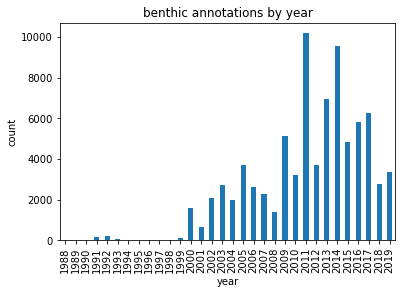

In [3]:
df = pd.read_csv('old/benthic_concepts_per_year.csv', index_col=0)
df.sum(axis=0).plot(kind='bar', title='benthic annotations by year', xlabel='year', ylabel='count')

Per Lonny, annotations at MBARI really picked up post-2000. The shape of this plot is not a FathomNet specific issue; there just aren't that many early annotations from MBARI data. 

Stands to reason that we should focus our efforts just in the past two decades. 

## By concept
Look at the concept distribution of all the data

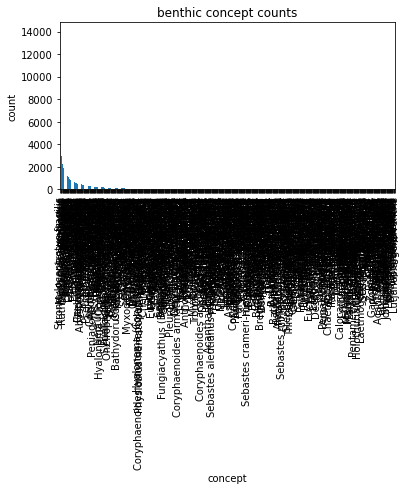

In [4]:
fig, ax = plt.subplots()
df.sum(axis=1).sort_values(ascending=False).plot(kind='bar', 
                                                 title='benthic concept counts', 
                                                 xlabel='concept', 
                                                 ylabel='count', 
                                                 ax=ax)
fig.subplots_adjust(bottom=0.3)

So long-tailed. Now just look at the concepts that have more than 100 localizations.

(110,)


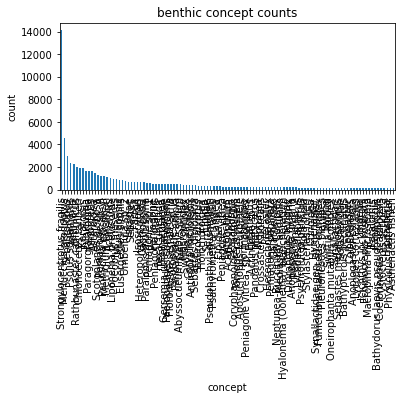

In [66]:
fig, ax = plt.subplots()
tmp = df.sum(axis=1).sort_values(ascending=False)
tmp[tmp > 100].plot(kind='bar', 
                    title='benthic concept counts', 
                    xlabel='concept', 
                    ylabel='count', 
                    ax=ax)
fig.subplots_adjust(bottom=0.3)

print(tmp[tmp > 100].shape)

There are still 110 concepts with more than 100 localizations. Maybe setting 200 as the threshold will be more legible.

(73,)


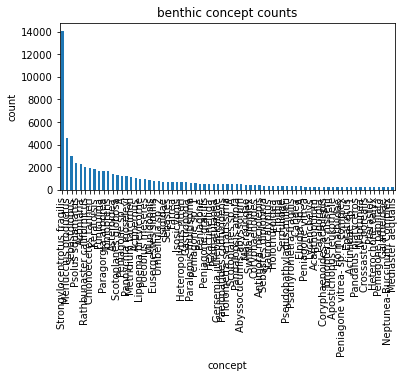

In [5]:
fig, ax = plt.subplots()
tmp = df.sum(axis=1).sort_values(ascending=False)
tmp[tmp > 200].plot(kind='bar', 
                    title='benthic concept counts', 
                    xlabel='concept', 
                    ylabel='count', 
                    ax=ax)
fig.subplots_adjust(bottom=0.3)

print(tmp[tmp > 200].shape)

## By region

Divide the data up by geographic region according to coordinates availabe in the DSG (derived sort of hackily from the [data panel for Nanomia bijuga](http://dsg.mbari.org/dsg/plots/concept/Nanomia%20bijuga/Davidson%20Seamount)). Here are the regions, with `ca_borderland` `max-latitude` adjusted to 35.38 from 37.6 to avoid overlap with `great_mb`:

In [3]:
regions, regions_df = mbari_regions()

# sort the regions by latitude 
regions_df.sort_values('max-latitude', inplace=True)

regions_df

,max-latitude,min-latitude,max-longitude,min-longitude
hi,23.4,18.25,-154.2,-161.27
goc,32.37,22.496,-106.498,-116.332
rqz_seamount,34.19,33.865,-120.86,-121.26
station_m,35.2521,35.0375,-122.8026,-123.1858
ca_borderland,35.38,32.58,-117.2,-122.7
davidson_seamount,35.9,35.5,-122.5,-122.9
mars,36.714,36.707,-122.182,-122.192
taney_seamount,36.95,36.5,-124.745,-124.945
mb,37.0538,36.4458,-121.7805,-122.5073
great_mb,37.199,35.38,-121.0046,-123.8479


Some notes regarding regions:
- `mars` is data from around the cabled observatory that MBARI manages. Those coordinates are inside the `mb` region. Worth investigating if those are camera trap images or ones collected by an ROV.
- `station_m` is inside the area described by `ca_borderland`. Worth investigating if those are camera trap images or ones collected by an ROV.
- `mb` is inscribed in `greater_mb`. All images collected in `mb` are also represented in `great_mb`

This next cell can take awhile to run (~11 minutes). The output CSV is saved in this repo for easy access. 

In [ ]:
# RUN THIS CELL IF RETRIVAL NEEDED

from fathomnet.models import GeoImageConstraints
from fathomnet.api import images, boundingboxes
from tqdm import notebook

inds = pd.MultiIndex.from_product([concepts, ['images', 'bboxes']], names=['concept','count-type'])  # for multi index array
df = pd.DataFrame(columns=regions_df.index, index=inds)

# iterate over regions
for ii in notebook.tqdm(df.columns.to_list(), desc='regions'):
    #iterate over concepts  
    for cc in notebook.tqdm(concepts, desc=f'concepts in {ii}', leave=False):
        tmp = GeoImageConstraints(concept=cc,
            maxLatitude=regions_df.at[ii, 'max-latitude'],
            minLatitude=regions_df.at[ii, 'min-latitude'],
            maxLongitude=regions_df.at[ii, 'max-longitude'],
            minLongitude=regions_df.at[ii, 'min-longitude']
        )

        # get the relevant images from region
        imgs = images.find(tmp)

        # get the number of bounding boxes in those images
        numbox = 0
        for im in imgs:
            numbox += len(list(filter(lambda box: box.concept == cc, im.boundingBoxes)))

        # set values in array
        df.loc[(cc, 'images'), ii] = len(imgs)  # number of images with the concept
        df.loc[(cc, 'bboxes'), ii] = numbox  # number of bboxes in those images

# save to this directory
df.sort_index()
df.to_csv('benthic_counts_region.csv')

In [4]:
# RUN THIS CELL TO LOAD REGION COUNTS FROM DISK
counts_df = pd.read_csv('benthic_counts_region.csv', index_col=['concept','count-type'])

In [5]:
counts_df

ca_borderland  davidson_seamount  eel_river  \
concept             count-type                                                
Actinauge verrillii images                  0                  0          0   
                    bboxes                  0                  0          0   
Actinernus          images                220                  1          0   
                    bboxes                802                  1          0   
Actiniaria          images                177                 16         16   
...                                       ...                ...        ...   
Tomopteridae        bboxes                  0                  0          0   
Tomopteris          images                  5                 34          0   
                    bboxes                  5                 34          0   
Tomopteris nisseni  images                  0                  1          0   
                    bboxes                  0                  1          0   

                                great_mb  gpg_seamounts  goc  hi  jdf  mars  \
concept             count-type                                                
Actinauge verrillii images             0              0    0   0    0     0   
                    bboxes             0              0    0   0    0     0   
Actinernus          images            80              0    7   1    0     0   
                    bboxes           197              0   13   1    0     0   
Actiniaria          images           728             16   41   7    1    53   
...                                  ...            ...  ...  ..  ...   ...   
Tomopteridae        bboxes            14              0    0   0    0     0   
Tomopteris          images          1405              1  143   0    0     2   
                    bboxes          1430              1  175   0    0     2   
Tomopteris nisseni  images           231              1    0   0    0     5   
                    bboxes           233              1    0   0    0     5   

                                 mb  pac_nw  rqz_seamount  station_m  \
concept             count-type                                         
Actinauge verrillii images        0       0             0          1   
                    bboxes        0       0             0          1   
Actinernus          images       70      14             2          0   
                    bboxes      178      17             2          0   
Actiniaria          images      522      58             2          6   
...                             ...     ...           ...        ...   
Tomopteridae        bboxes        9       1             0          0   
Tomopteris          images      890       8             0          0   
                    bboxes      903       8             0          0   
Tomopteris nisseni  images      161       3             0          0   
                    bboxes      163       3             0          0   

                                taney_seamount  vance_seamount  
concept             count-type                                  
Actinauge verrillii images                   0               0  
                    bboxes                   0               0  
Actinernus          images                   0               0  
                    bboxes                   0               0  
Actiniaria          images                   0               0  
...                                        ...             ...  
Tomopteridae        bboxes                   0               0  
Tomopteris          images                   0               0  
                    bboxes                   0               0  
Tomopteris nisseni  images                   0               0  
                    bboxes                   0               0  

[1240 rows x 15 columns]

In [4]:
counts_df = counts_df.sort_index()  # sort index if not already

# print the counts of each type in each region and number of concepts
pd.DataFrame((counts_df.xs("images", level="count-type").sum(), 
    counts_df.xs("bboxes", level="count-type").sum(),
    counts_df.xs("bboxes", level="count-type")[counts_df.xs("bboxes", level="count-type") != 0].count()), 
    index=["images","bboxes","num-concepts"]
).T

,images,bboxes,num-concepts
ca_borderland,3118,6734,175
davidson_seamount,1163,1436,117
eel_river,271,669,46
great_mb,30978,59146,446
gpg_seamounts,480,730,68
goc,2924,4258,188
hi,136,145,46
jdf,395,470,51
mars,949,2614,64
mb,20477,44077,347


### Distances between regions
#### Bray-Curtis dissimilarity 
Use [Bray-Curtis](https://en.wikipedia.org/wiki/Bray%E2%80%93Curtis_dissimilarity) (BC) dissimilarity to quantify how different the regions are taxonomically. BC is bounded \[0,1\] with 0 suggesting the regions are taxonomically identical and 1 suggesting there is no species overlap.

Compare `mb` and `ca_borderland` bbox counts with the distance.

In [12]:
# pull out the boudning boxes from the two regions
tmp = counts_df.xs("bboxes", level="count-type")[['ca_borderland', 'mb']]
tmp

,ca_borderland,mb
concept,,
Abyssocucumis abyssorum,0,14
Acanthascinae,0,30
Acanthascinae sp. 1-4 complex,3,3
Acanthascinae sp. 2,0,7
Acanthascinae sp. 4,0,0
...,...,...
Ziminella vrijenhoeki,0,2
Zoarcidae,0,5
Zoroaster spinulosus,0,0


Compute [Bray-Curtis](https://en.wikipedia.org/wiki/Bray%E2%80%93Curtis_dissimilarity) by hand and with [scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.braycurtis.html) as a sanity check.

In [13]:
# using the wikipedia forumlation
bcwiki = 1 - float(2*tmp[['ca_borderland', 'mb']].min(axis=1).sum())/ \
    float(tmp[['ca_borderland', 'mb']].sum().sum())

# using scipy
bcscipy = braycurtis(tmp['mb'].to_numpy(), tmp['ca_borderland'].to_numpy())

print(f'BC from scipy = {bcscipy}\n\
BC from wikipedia = {bcwiki}', )

BC from scipy = 0.8074432701580366
BC from wikipedia = 0.8074432701580366


Just use the scipy version since it is cleaner. Now compute all BC values pairwise between the regions.

taney_seamount not found in the data


Text(0, 0.5, 'Bray-Curtis Dissimilarity')

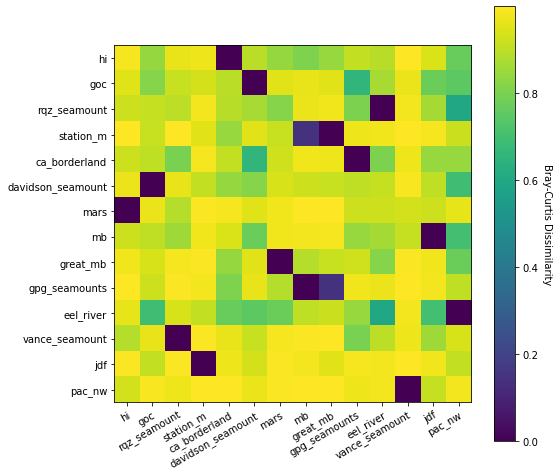

In [5]:
tmp = counts_df.xs("bboxes", level="count-type")
tmp = tmp.drop('taney_seamount', axis=1)  # drop Taney Seamount since there are no labels

outbc = pairwise_bc(tmp, order=regions_df.index.to_list())

fig, ax = plt.subplots(figsize=(8,8))
im, cbar = heatmap(outbc.to_numpy(), 
    row_labels=outbc.columns.to_list(), 
    col_labels=outbc.columns.to_list(), 
    ax=ax, 
    cmap='viridis'
)
cbar.ax.set_ylabel('Bray-Curtis Dissimilarity', rotation=-90, va="bottom")

#### L1 distance between normalized distribution
Compute the L1 distance between the normalized per-concept distribtuion in each region. This is akin to the computation make in [Beery et al., 2022](https://openaccess.thecvf.com/content/CVPR2022/papers/Beery_The_Auto_Arborist_Dataset_A_Large-Scale_Benchmark_for_Multiview_Urban_CVPR_2022_paper.pdf) to look at the distance between tree class distributions. Unfortunately, the concepts in our benthic list are not all at the same level of the taxonomic tree so these calculations are not exactly one-to-one with Sara's paper. 

Text(0, 0.5, 'L1-distance btwn normalized class counts')

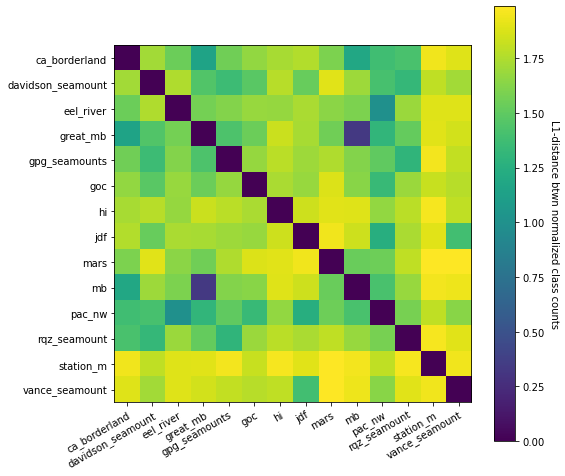

In [6]:
outL1 = pairwise_L1_dist(tmp)

fig, ax = plt.subplots(figsize=(8,8))
im, cbar = heatmap(outL1.to_numpy(), 
    row_labels=outL1.columns.to_list(), 
    col_labels=outL1.columns.to_list(), 
    ax=ax, 
    cmap='viridis'
)
cbar.ax.set_ylabel('L1-distance btwn normalized class counts', rotation=-90, va="bottom")

## By depth
Pull down data by depth in Monterey Bay. Once again this takes awhile since there are thousands of individual API calls happening. 

In [ ]:
# RUN THIS CELL IF RETRIVAL NEEDED

from fathomnet.models import GeoImageConstraints
from fathomnet.api import images, boundingboxes
from tqdm import notebook

depths = np.arange(0,4100,100, dtype=np.float64)  # depth horizons in meters

inds = pd.MultiIndex.from_product([concepts, ['images', 'bboxes']], names=['concept','count-type'])  # for multi index array
df = pd.DataFrame(columns=depths, index=inds)

# iterate over depths
for ii, vv in enumerate(notebook.tqdm(depths[0:-1], desc='regions')):
    #iterate over concepts  
    for cc in notebook.tqdm(concepts, desc=f'concepts in {ii}', leave=False):
        tmp = GeoImageConstraints(concept=cc,
            maxLatitude=regions_df.at['great_mb', 'max-latitude'],
            minLatitude=regions_df.at['great_mb', 'min-latitude'],
            maxLongitude=regions_df.at['great_mb', 'max-longitude'],
            minLongitude=regions_df.at['great_mb', 'min-longitude'],
            minDepth=depths[ii],
            maxDepth=depths[ii+1]-0.1
        )

        # get the relevant images from region
        imgs = images.find(tmp)

        # get the number of bounding boxes in those images
        numbox = 0
        for im in imgs:
            numbox += len(list(filter(lambda box: box.concept == cc, im.boundingBoxes)))

        # set values in array
        df.loc[(cc, 'images'), vv] = len(imgs)  # number of images with the concept
        df.loc[(cc, 'bboxes'), vv] = numbox  # number of bboxes in those images

# save to this directory
df.sort_index()
df.to_csv('gmb_counts_depth.csv')

In [7]:
# RUN THIS TO LOAD DEPTH COUNTS FROM DISK
depth_df = pd.read_csv('gmb_counts_depth.csv', index_col=['concept','count-type'])  # counts in 100-m depth bins in Greater MB

In [8]:
depth_df = depth_df.sort_index()  # sort index if not already

# print the counts of each type in each region and number of concepts
pd.DataFrame((depth_df.xs("images", level="count-type").sum(), 
    depth_df.xs("bboxes", level="count-type").sum(),
    depth_df.xs("bboxes", level="count-type")[depth_df.xs("bboxes", level="count-type") != 0].count()), 
    index=["images","bboxes","num-concepts"]
).T

,images,bboxes,num-concepts
0.0,620.0,1083.0,66.0
100.0,920.0,1697.0,72.0
200.0,1796.0,5085.0,100.0
300.0,3112.0,7064.0,116.0
400.0,2943.0,4865.0,108.0
500.0,2074.0,6372.0,92.0
600.0,2230.0,4631.0,131.0
700.0,1057.0,1893.0,96.0
800.0,2709.0,5620.0,144.0
900.0,1838.0,3112.0,116.0


### Bray-Curtis

Text(0, 0.5, 'Bray-Curtis Dissimilarity')

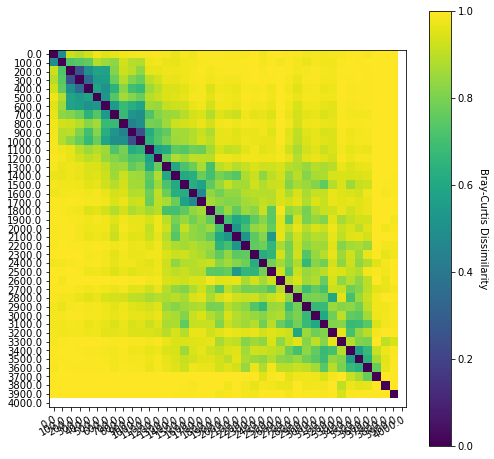

In [9]:
tmp = depth_df.xs("bboxes", level="count-type")

outbc = pairwise_bc(tmp)

fig, ax = plt.subplots(figsize=(8,8))
im, cbar = heatmap(outbc.to_numpy(), 
    row_labels=outbc.columns.to_list(), 
    col_labels=outbc.columns.to_list(), 
    ax=ax, 
    cmap='viridis'
)
cbar.ax.set_ylabel('Bray-Curtis Dissimilarity', rotation=-90, va="bottom")

### L1-distance of normalized concept counts

Text(0, 0.5, 'L1-distance btwn normalized class counts')

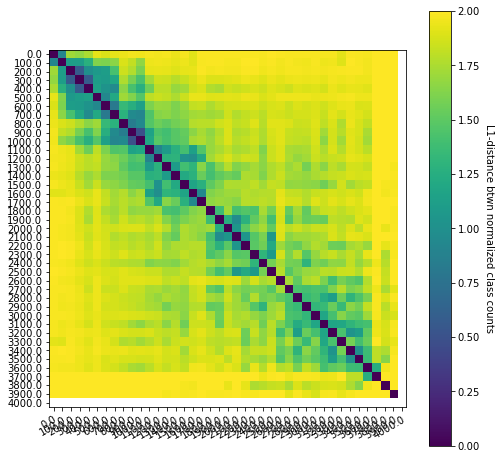

In [10]:
outL1 = pairwise_L1_dist(tmp)

fig, ax = plt.subplots(figsize=(8,8))
im, cbar = heatmap(outL1.to_numpy(), 
    row_labels=outL1.columns.to_list(), 
    col_labels=outL1.columns.to_list(), 
    ax=ax, 
    cmap='viridis'
)
cbar.ax.set_ylabel('L1-distance btwn normalized class counts', rotation=-90, va="bottom")

## By camera

This will be sort of hacky as there currently is not a field in FathomNet for camera used to collect the image. But there are these date ranges for cameras deployed on each ROV.

| rov_name | camera_name | start_date | end_date | fov_width_pixels | fov_height_pixels |
| --- | --- | --- | --- | --- | --- |  
| Doc Ricketts | Ikegami HDL40  | 2/10/2009 12:00:00 AM | 12/31/2019 11:59:00 PM | 1920 | 1080 |
| Tiburon | Panasonic 3-chip | 10/29/1996 12:00:00 AM | 9/23/2005 11:59:00 PM | 720 | 480 |
| Tiburon | Ikegami HDL40 | 10/4/2005 12:00:00 AM | 12/20/2007 11:59:00 PM | 1920 | 1080 |
| Ventana | Sony 3-chip | 8/25/1988 12:00:00 AM | 8/25/1999 11:59:00 PM | 720 | 480 |
| Ventana | Sony HDTV | 9/3/1999 12:00:00 AM | 7/9/2007 11:59:00 PM | 1920 | 1080 |
| Ventana | Sony 3-chip | 7/11/2007 12:00:00 AM | 7/31/2007 11:59:00 PM | 720 | 480 |
| Ventana | Ikegami HDL40 | 8/2/2007 12:00:00 AM | 12/31/2019 11:59:00 PM | 1920 | 1080 |

First make the table into a dictonary.

In [3]:
cams = {'Doc%20Ricketts': {'ikegami': ['2009-02-10', '2019-12-31']},
        'Tiburon': {'panasonic': ['1996-10-29', '2005-09-23'],
                    'ikegami': ['2005-10-04', '2007-12-20']},
        'Ventana': {'sonyChip': ['2007-07-11', '2007-07-31'],
                    'sonyHD': ['1999-09-03', '2007-07-09'],
                    'ikegami': ['2008-08-02', '2019-12-31']}
       }

In [4]:
# RUN THIS CELL TO RETRIEVE COUNTS

from fathomnet.models import GeoImageConstraints
from fathomnet.api import images, boundingboxes
from tqdm import notebook

inds = pd.MultiIndex.from_product([concepts, ['images', 'bboxes']], names=['concept','count-type'])  # for multi index array
cols = pd.MultiIndex.from_arrays([['Doc%20Ricketts', 'Tiburon', 'Tiburon', 'Ventana', 'Ventana', 'Ventana'], 
    ['ikegami', 'panasonic','ikegami','sonyChip', 'sonyHD','ikegami']], names=['vehicle','camera'])
df = pd.DataFrame(columns=cols, index=inds)

for ii in (notebook.tqdm(df.columns.to_list())):
    st_time = datetime.datetime.fromisoformat(cams[ii[0]][ii[1]][0])
    ed_time = datetime.datetime.fromisoformat(cams[ii[0]][ii[1]][1])
    for cc in notebook.tqdm(concepts, desc=f'concepts for {ii[0]}, {ii[1]}', leave=False):
        tmp = GeoImageConstraints(concept=cc,
            startTimestamp=st_time.isoformat(timespec='milliseconds') + 'Z',
            endTimestamp=ed_time.isoformat(timespec='milliseconds') + 'Z'
        )

        # get the relevant images during the time frame
        imgs = images.find(tmp)

        # filter by vehicle name in url and count imgs and bboxes
        numimgs = 0
        numbox = 0
        for im in imgs:
            if ii[0] in im.url:
                numimgs += 1
                numbox += len(list(filter(lambda box: box.concept == cc, im.boundingBoxes)))

        # set values in array
        df.loc[(cc, 'images'), (ii[0], ii[1])] = numimgs  # number of images with the concept
        df.loc[(cc, 'bboxes'), (ii[0], ii[1])] = numbox  # number of bboxes in those images

df.sort_index()
df.to_csv('mbari_counts_camera.csv')

  0%|          | 0/6 [00:00<?, ?it/s]

concepts for Doc%20Ricketts, ikegami:   0%|          | 0/620 [00:00<?, ?it/s]

concepts for Tiburon, panasonic:   0%|          | 0/620 [00:00<?, ?it/s]

concepts for Tiburon, ikegami:   0%|          | 0/620 [00:00<?, ?it/s]

concepts for Ventana, sonyChip:   0%|          | 0/620 [00:00<?, ?it/s]

concepts for Ventana, sonyHD:   0%|          | 0/620 [00:00<?, ?it/s]

concepts for Ventana, ikegami:   0%|          | 0/620 [00:00<?, ?it/s]

In [11]:
# RUN THIS CELL TO READ FROM DISK
cam_df = pd.read_csv('mbari_counts_camera.csv', header=[0,1], index_col=[0,1])

vehicle             Doc%20Ricketts   Tiburon          Ventana               
camera                     ikegami panasonic ikegami sonyChip sonyHD ikegami
concept                                                                     
Actinauge verrillii              0         0       1        0      0       0
Actinernus                     878       135      14        0      0       0
Actiniaria                    1429       237      78        0    189     305
Actiniidae                       0         0       0        0      0       0
Actiniidae sp. 1               101        11      28        0     21      57
...                            ...       ...     ...      ...    ...     ...
Terebellidae                     5         0       0        0      0       0
Tomopterid eggcase               8         0       0        0      0       0
Tomopteridae                    14         0       1        0      0       0
Tomopteris                    1244        62      36        0     45     241
Tomopteris nisseni              99        59      25        0     43      21

[620 rows x 6 columns]

In [24]:
xx = pd.DataFrame(cam_df.xs("images",level='count-type').sum(), columns=["images"])

xx.loc[:,'bboxes'] = cam_df.xs("bboxes",level='count-type').sum()
xx.loc[:,"num concepts"] = cam_df.xs("bboxes",level='count-type')[cam_df.xs("bboxes",level='count-type') != 0].count()

xx

images  bboxes  num concepts
vehicle        camera                                 
Doc%20Ricketts ikegami     25823   44505           477
Tiburon        panasonic    4365    6850           273
               ikegami      2382    3260           215
Ventana        sonyChip        4       4             2
               sonyHD       3501    6851           147
               ikegami      8159   18589           245